# Análise dos áudios originais (amostras do dataset) - Espectrogramas, ondas e Sample Rate

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import librosa.display
import os
import glob
import pandas
import pyloudnorm as pyln
import soundfile as sf
from random import shuffle
from tqdm import tqdm_notebook
from pydub import AudioSegment
from scipy.fftpack import fft
from scipy import signal

In [2]:
%matplotlib inline 
color = sns.color_palette()
#py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

## Tópicos

1. __Espectrogramas__: Espectrogramas de todos os áudios (amostras da base original)
2. __Plot da onda__: Plots de todos os waveforms (amostras da base original)
3. __Gráfico das SRs__: Gráfico em pilhas das sample rates originais dos áudios

In [3]:
DATASET = "Respiratory_Sound_Database"
GROUP = "trim5"

## Carregar áudios

In [4]:
def load_wav_file(path):
    b, sr = sf.read(path) 
    return sr, b

In [5]:
data = pandas.DataFrame(columns=['path', 'name', 'sr', 'time_series', 'label', 'class'])
data['path'] = glob.glob(f'./datasets/{GROUP}/**/*.wav', recursive=True)
data['name'] = data['path'].apply(lambda p: os.path.splitext(os.path.basename(p))[0])
wavs = [load_wav_file(p) for p in data['path']]
data['time_series'] = [wav[1] for wav in wavs]
data['sr'] = [wav[0] for wav in wavs]
data['nframes'] = data['time_series'].apply(len)

## Carregar CSV

In [6]:
csv = open('./Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv').readlines()
data_labels = dict()
for line in csv:
    data_labels[line.split(',')[0]] = line.split(',')[1].rstrip()
data['label'] = data['name'].apply(lambda n: data_labels[n.split('_')[0]])

In [7]:
data.head()

path  \
0  ./datasets/trim5/Pneumo_Healthy_Only/209_1b1_T...   
1  ./datasets/trim5/Pneumo_Healthy_Only/209_1b1_T...   
2  ./datasets/trim5/Pneumo_Healthy_Only/209_1b1_T...   
3  ./datasets/trim5/Pneumo_Healthy_Only/226_1b1_P...   
4  ./datasets/trim5/Pneumo_Healthy_Only/226_1b1_P...   

                                                name     sr  \
0  209_1b1_Tc_sc_Meditron__remix__rate44100__norm...  44100   
1  209_1b1_Tc_sc_Meditron__remix__rate44100__norm...  44100   
2  209_1b1_Tc_sc_Meditron__remix__rate44100__norm...  44100   
3  226_1b1_Pl_sc_LittC2SE__remix__rate44100__norm...  44100   
4  226_1b1_Pl_sc_LittC2SE__remix__rate44100__norm...  44100   

                                         time_series      label class  nframes  
0  [0.08041603257879615, 0.08080451563000679, 0.0...    Healthy   NaN   220500  
1  [0.15026532066985965, 0.15088689420372248, 0.1...    Healthy   NaN   220500  
2  [-0.035972943529486656, -0.03239889768883586, ...    Healthy   NaN   220500  
3  [-0.14142523799091578, -0.14034672686830163, -...  Pneumonia   NaN   220500  
4  [0.18329996103420854, 0.18264347640797496, 0.1...  Pneumonia   NaN   220500

## Gráficos

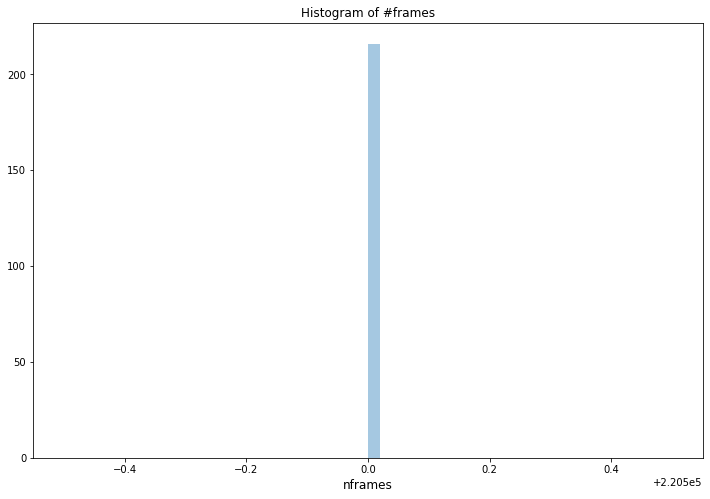

In [8]:
plt.figure(figsize=(12,8))
sns.distplot(data.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

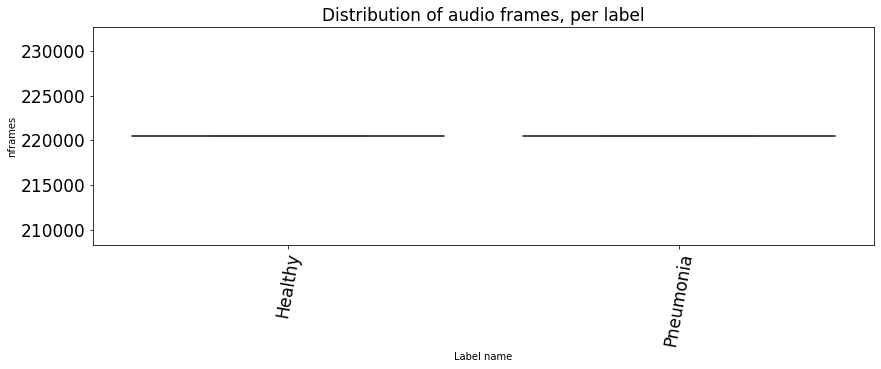

In [9]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=data)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

Total number of labels in training data :  2
Labels are :  ['Healthy' 'Pneumonia']


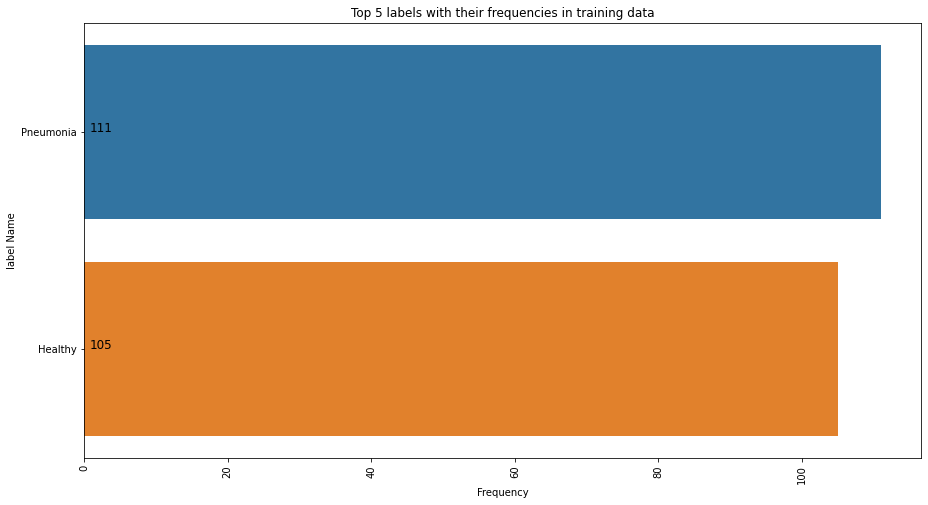

In [10]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [11]:
temp = data['sr'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

count
label     sr          
Healthy   44100    105
Pneumonia 44100    111

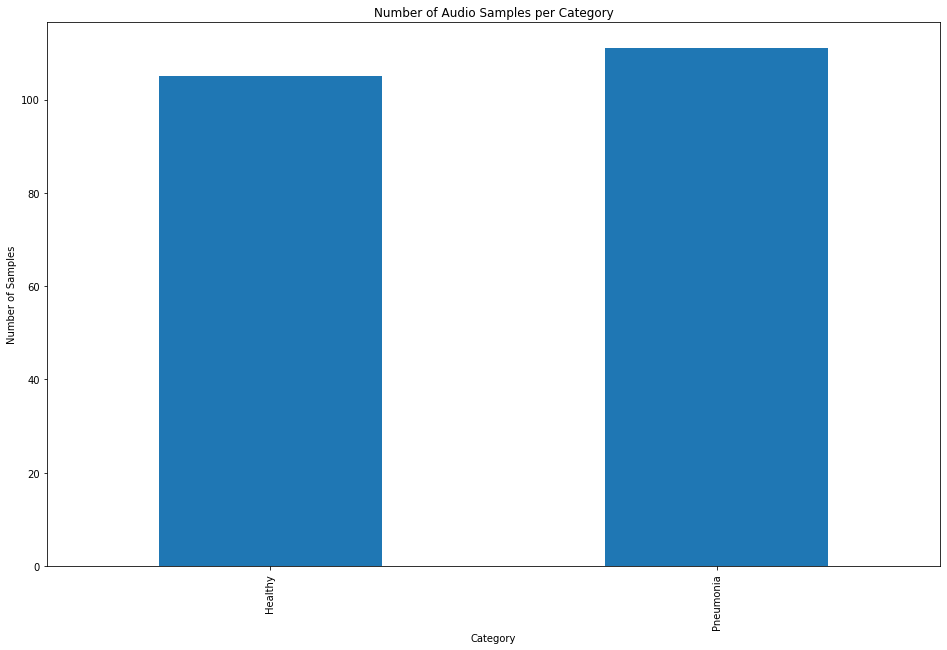

In [12]:
temp = pandas.DataFrame(zip(data['path'], data['label'], data['sr']), 
                        columns=['count', 'label', 'sr'])

category_group = temp.groupby(['label', 'sr']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

---

In [13]:
samples = data.sample(n=40, random_state=1)

In [14]:
print("Size of training data", data.shape)

Size of training data (216, 7)


## Waveform 

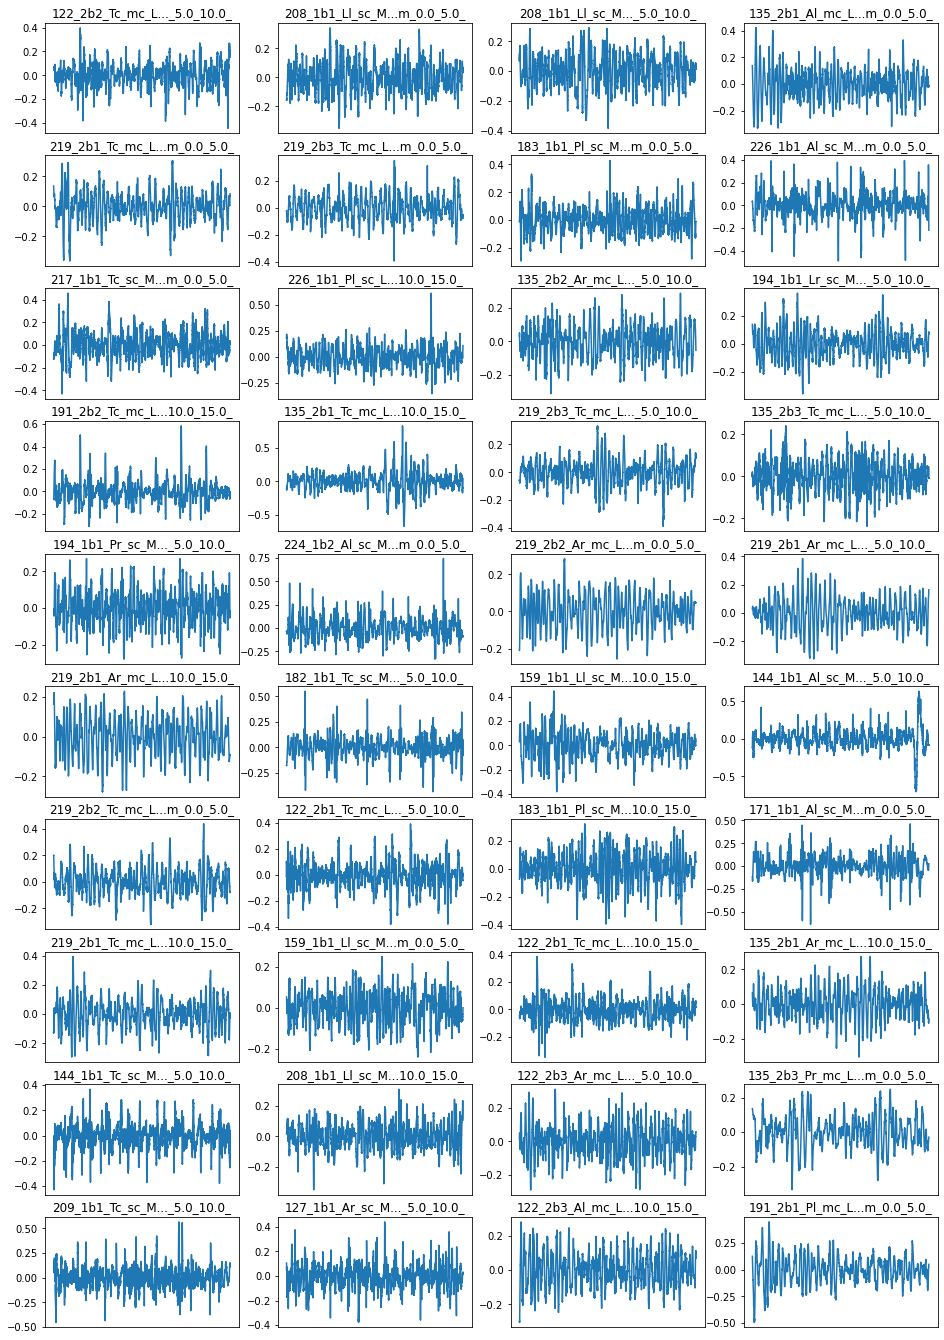

In [15]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['name'][idx][:15] + '...' + samples['name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    #ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [16]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [17]:
sr, b, nframes = data['sr'][0], data['time_series'][0], data['nframes'][0]

Text(0.5, 0, 'Seconds')

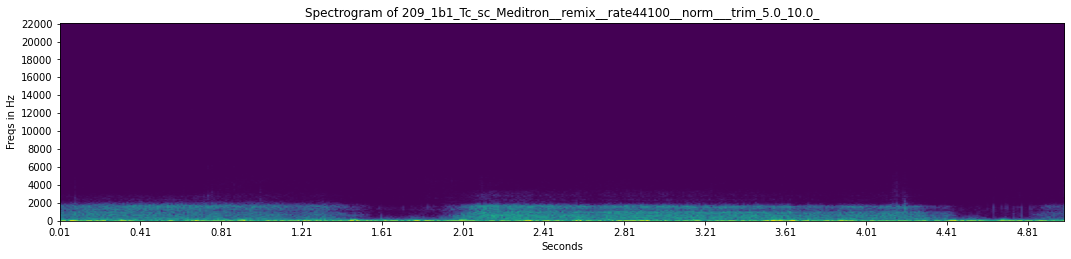

In [18]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['name'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

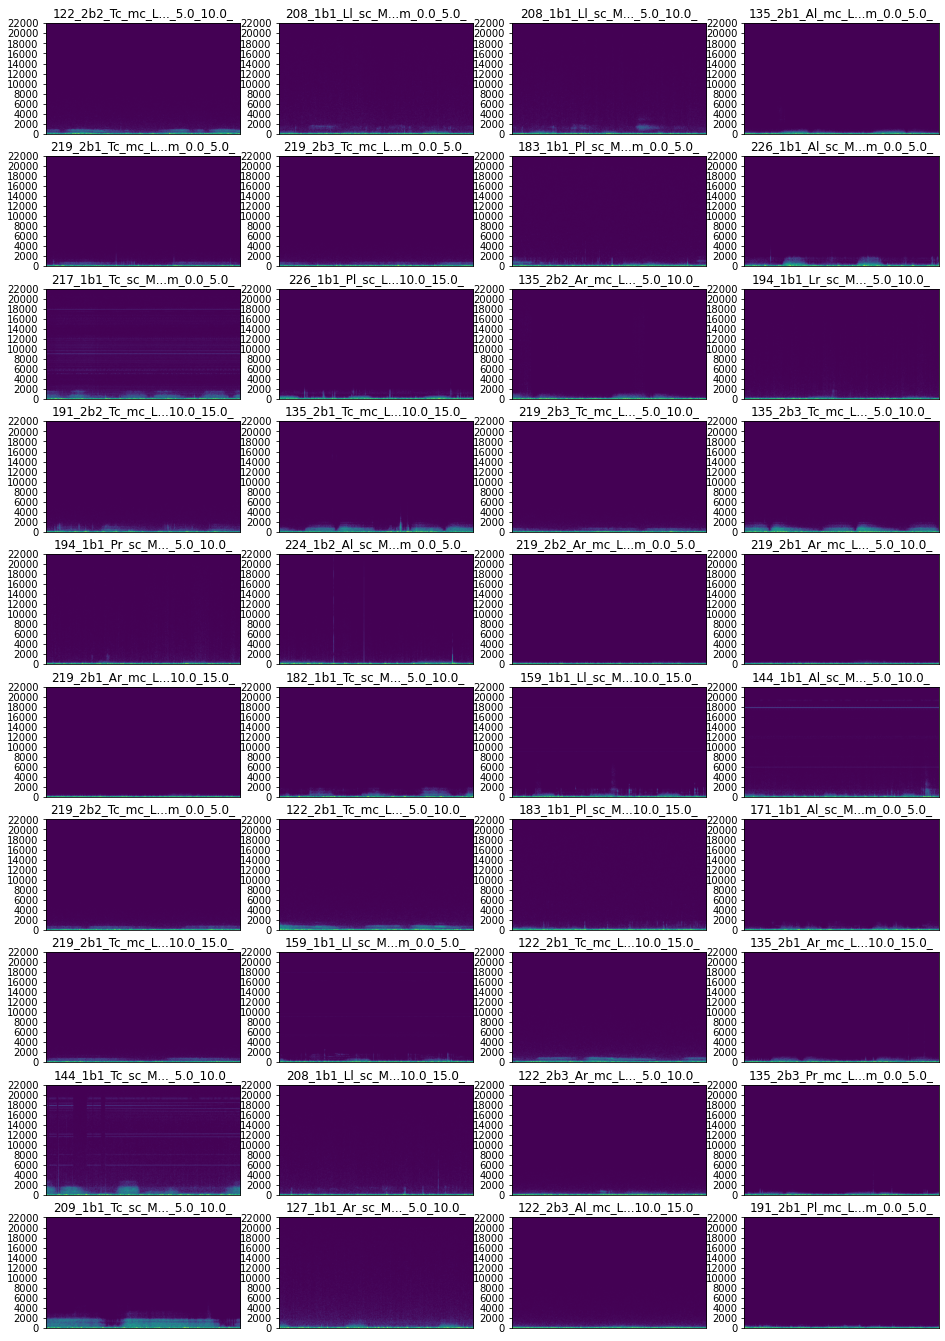

In [19]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower',
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['name'][idx][:15] + '...' + samples['name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [20]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

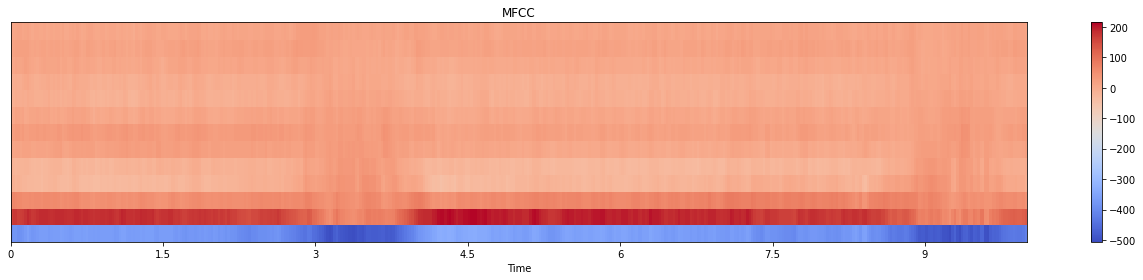

In [21]:
freqs, times, spectrogram = mfcc_specgram(b, sr, nframes)
fig = plt.figure(figsize=(18, 4))
librosa.display.specshow(spectrogram, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()
plt.close()
    

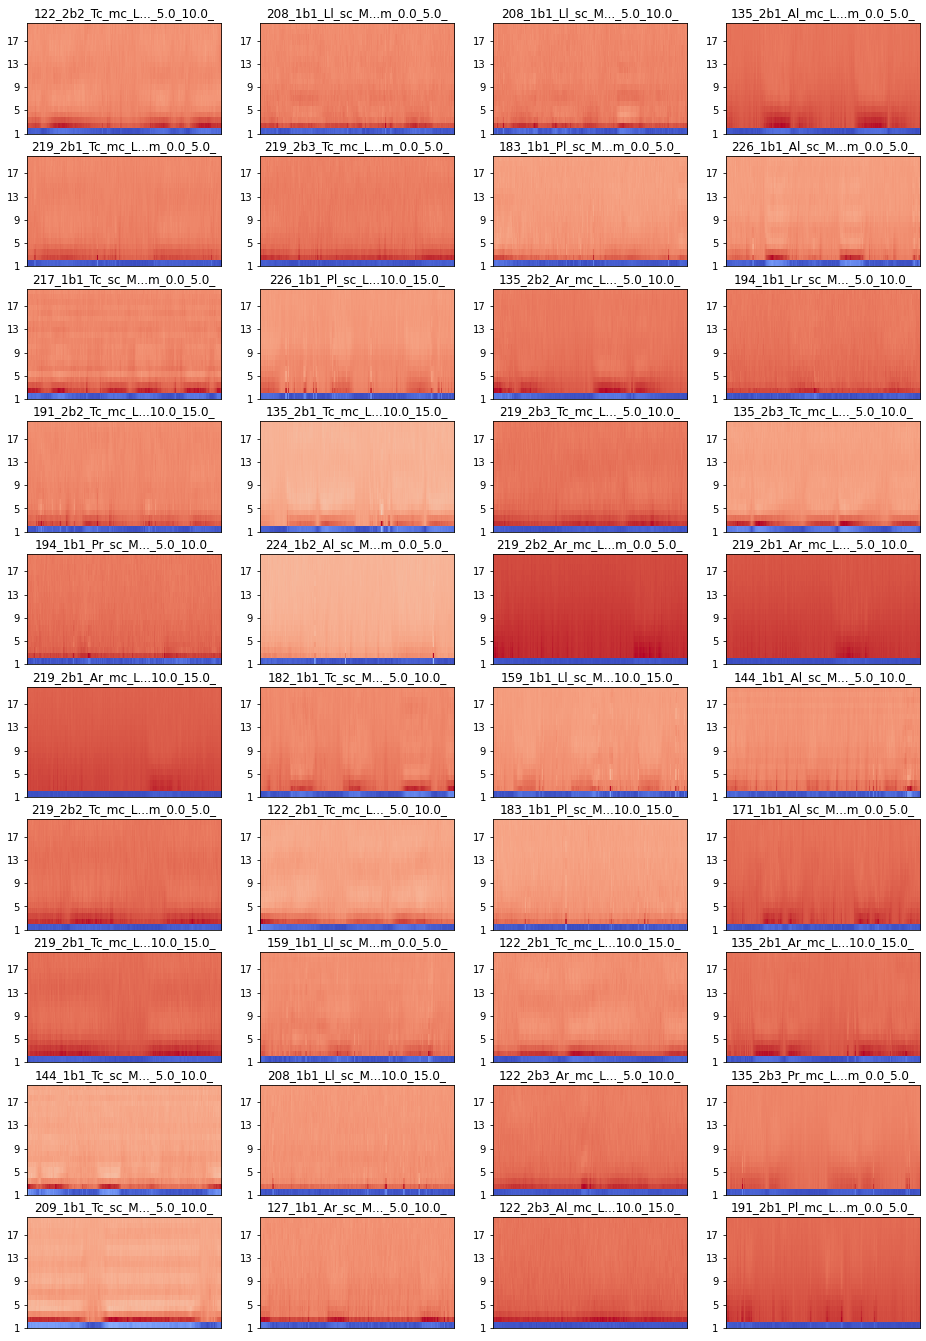

In [22]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', interpolation='nearest', cmap='coolwarm',
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['name'][idx][:15] + '...' + samples['name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

## Delta

In [23]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

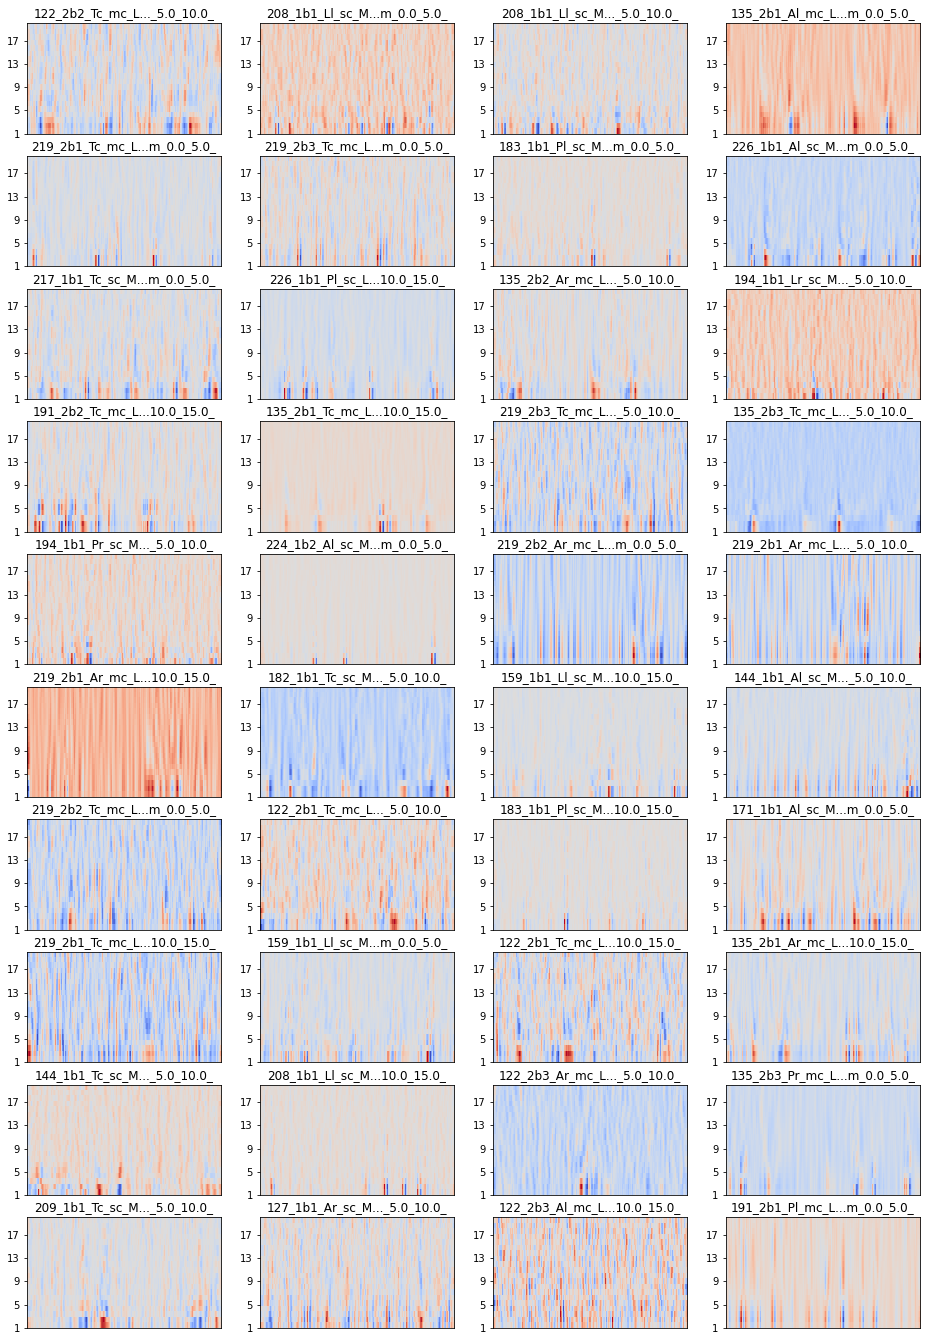

In [24]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', interpolation='nearest', cmap='coolwarm',
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['name'][idx][:15] + '...' + samples['name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [25]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

In [ ]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', interpolation='nearest', cmap='coolwarm',
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['name'][idx][:15] + '...' + samples['name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  